In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/cleaned_cincinati_data.csv')

<ipython-input-56-6aa5d32d9b0e>:1: DtypeWarning: Columns (0,7,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Datasets/cleaned_cincinati_data.csv')


In [57]:
data.head()

,INCIDENT_NO,DATE_REPORTED,DATE_FROM,DATE_TO,CLSD,UCR,DST,BEAT,OFFENSE,LOCATION,...,SUSPECT_RACE,SUSPECT_ETHNICITY,SUSPECT_GENDER,TOTALNUMBERVICTIMS,TOTALSUSPECTS,UCR_GROUP,ZIP,SNA_NEIGHBORHOOD,date_reported,time_reported
0,229033241,12/13/2022 11:11:00 PM,12/13/2022 10:00:00 PM,12/13/2022 10:00:00 PM,F--CLEARED BY ARREST - ADULT,1493.0,3,3,CRIMINAL DAMAGING/ENDANGERING,02-MULTI FAMILY APARTMENT,...,NaN,NOT OF HISPANIC ORIG,MALE,1.0,1.0,PART 2 MINOR,45211.0,WESTWOOD,2022-12-13,11:11:00 PM
1,229033230,12/13/2022 08:55:20 PM,12/13/2022 03:00:00 AM,12/13/2022 03:30:00 AM,Z--EARLY CLOSED,810.0,4,3,ASSAULT,02-MULTI FAMILY,...,NaN,NOT OF HISPANIC ORIG,MALE,1.0,1.0,PART 2 MINOR,45229.0,AVONDALE,2022-12-13,08:55:20 PM
2,229033231,12/13/2022 07:36:00 PM,12/13/2022 07:20:00 PM,12/13/2022 07:35:00 PM,D--VICTIM REFUSED TO COOPERATE,303.0,4,6,AGGRAVATED ROBBERY,48-PARKING LOT,...,NaN,NOT OF HISPANIC ORIG,MALE,1.0,2.0,ROBBERY,45216.0,CARTHAGE,2022-12-13,07:36:00 PM
3,229033231,12/13/2022 07:36:00 PM,12/13/2022 07:20:00 PM,12/13/2022 07:35:00 PM,D--VICTIM REFUSED TO COOPERATE,303.0,4,6,AGGRAVATED ROBBERY,48-PARKING LOT,...,NaN,NOT OF HISPANIC ORIG,MALE,1.0,2.0,ROBBERY,45216.0,CARTHAGE,2022-12-13,07:36:00 PM
4,229033225,12/13/2022 06:59:00 PM,12/13/2022 06:45:00 PM,12/13/2022 06:50:00 PM,H--WARRANT ISSUED,802.0,3,2,AGGRAVATED MENACING,02-MULTI FAMILY APARTMENT,...,NaN,NOT OF HISPANIC ORIG,MALE,1.0,1.0,PART 2 MINOR,45205.0,EAST PRICE HILL,2022-12-13,06:59:00 PM


In [58]:
selected_columns = [
    'date_reported', 'time_reported', 'LOCATION', 'SNA_NEIGHBORHOOD',
    'ZIP', 'HATE_BIAS', 'TOTALNUMBERVICTIMS', 'TOTALSUSPECTS', 'UCR_GROUP', 'OFFENSE'
]
data_subset = data[selected_columns].copy()

In [59]:
data_subset.fillna({
    'LOCATION': 'Unknown',
    'SNA_NEIGHBORHOOD': 'Unknown',
    'HATE_BIAS': 'Unknown',
    'ZIP': 0,
    'UCR_GROUP': 'Unknown',
    'TOTALNUMBERVICTIMS': 0,
    'TOTALSUSPECTS': 0,
}, inplace=True)

In [60]:
data.to_csv('data.csv', index=False)

In [61]:
data_subset['hour_reported'] = pd.to_datetime(data_subset['time_reported'], errors='coerce').dt.hour.fillna(0).astype(int)
data_subset.drop(columns=['date_reported', 'time_reported'], inplace=True)

<ipython-input-61-97a372287ecc>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_subset['hour_reported'] = pd.to_datetime(data_subset['time_reported'], errors='coerce').dt.hour.fillna(0).astype(int)


In [62]:
categorical_columns = ['LOCATION', 'SNA_NEIGHBORHOOD', 'HATE_BIAS', 'UCR_GROUP', 'OFFENSE']
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data_subset[col] = label_encoders[col].fit_transform(data_subset[col])

In [63]:
scaler = MinMaxScaler()
numeric_columns = ['ZIP', 'TOTALNUMBERVICTIMS', 'TOTALSUSPECTS', 'hour_reported']
data_subset[numeric_columns] = scaler.fit_transform(data_subset[numeric_columns])

In [64]:
data_subset.head()

,LOCATION,SNA_NEIGHBORHOOD,ZIP,HATE_BIAS,TOTALNUMBERVICTIMS,TOTALSUSPECTS,UCR_GROUP,OFFENSE,hour_reported
0,8,49,0.082921,16,0.0,0.0000,3,15,1.000000
1,6,0,0.082954,16,0.0,0.0000,3,10,0.869565
2,54,4,0.082930,16,0.0,0.0625,5,6,0.826087
3,54,4,0.082930,16,0.0,0.0625,5,6,0.826087
4,8,12,0.082910,16,0.0,0.0000,3,4,0.782609


Outlier detection for

In [65]:
data_subset.to_csv('data_1.csv', index=False)

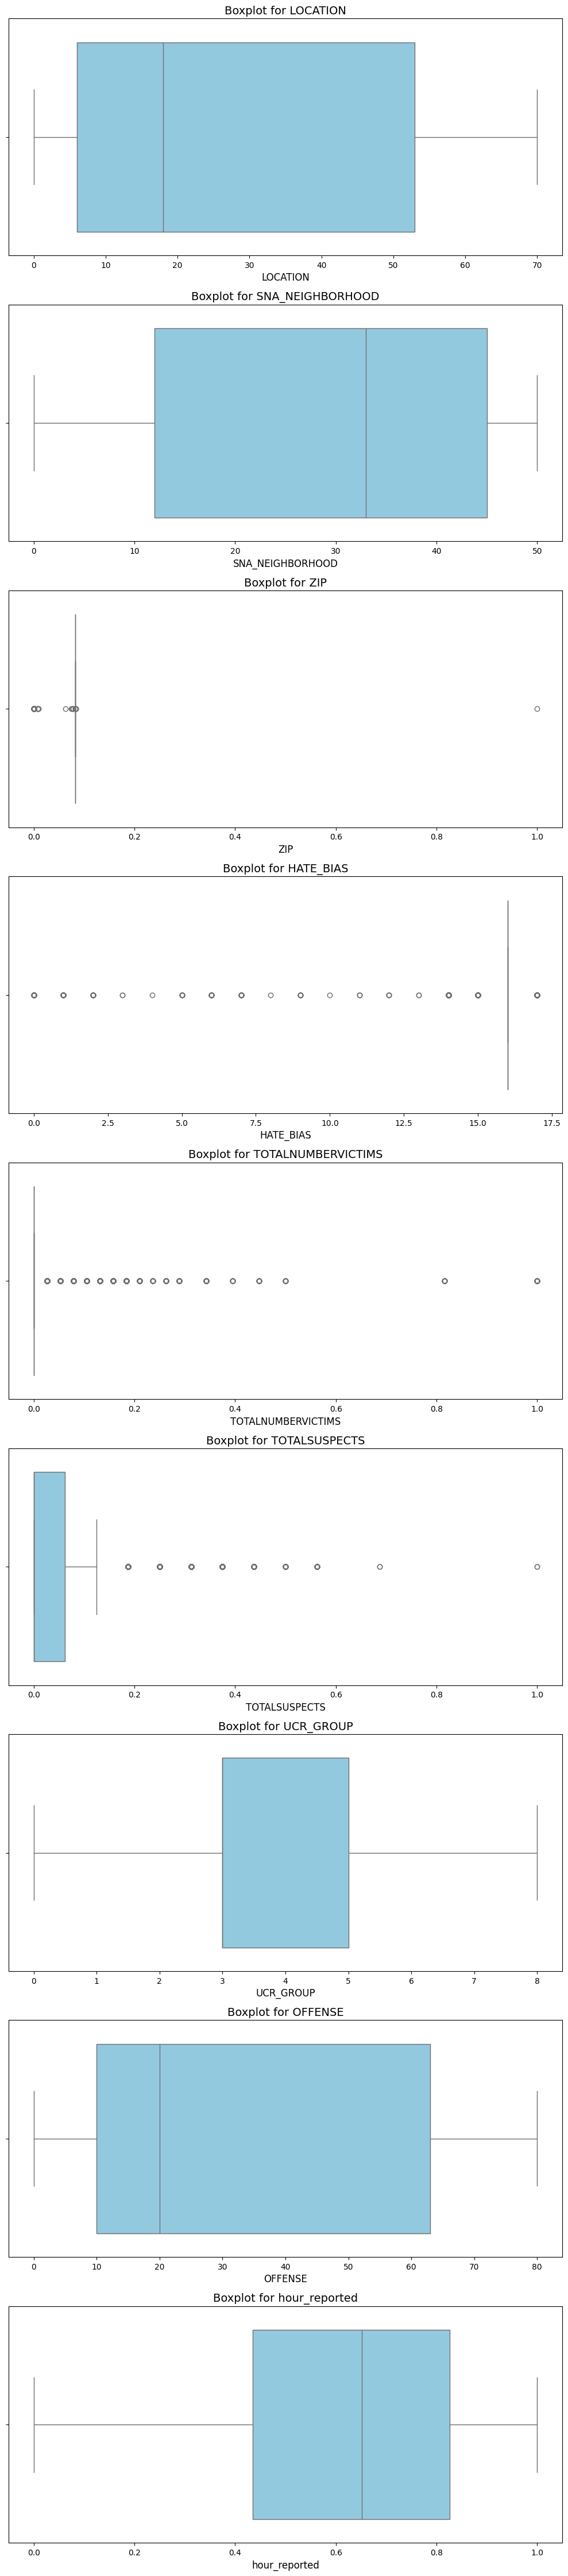

Outliers removed. Cleaned dataset saved as 'data_cleaned.csv'


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Function to plot outliers using boxplots
def plot_outliers(df):
    numeric_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns
    num_cols_count = len(numeric_cols)

    # Create subplots for each numeric column
    fig, axes = plt.subplots(num_cols_count, 1, figsize=(10, 5 * num_cols_count))
    if num_cols_count == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one column

    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot for {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    plt.tight_layout()
    plt.show()

# Function to drop outliers using IQR method
def drop_outliers(df):
    numeric_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns
    for col in numeric_cols:
      if col != 'TOTALNUMBERVICTIMS' and col != 'TOTALSUSPECTS' and col != 'HATE_BIAS':
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1               # Interquartile range
        lower_bound = Q1 - 1.5 * IQR # Lower bound
        upper_bound = Q3 + 1.5 * IQR # Upper bound

        # Remove rows outside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

# Step 1: Plot outliers
plot_outliers(data_subset)

# Step 2: Drop outliers
data_cleaned = drop_outliers(data_subset)

# Save the cleaned dataset
# data_cleaned.to_csv('/mnt/data/data_cleaned.csv', index=False)
data_subset = data_cleaned

print("Outliers removed. Cleaned dataset saved as 'data_cleaned.csv'")



In [67]:
# Calculate and print the number of null values in each column
null_counts = data_subset.isnull().sum()

print("Number of null values in each column:")
print(null_counts)


Number of null values in each column:
LOCATION              0
SNA_NEIGHBORHOOD      0
ZIP                   0
HATE_BIAS             0
TOTALNUMBERVICTIMS    0
TOTALSUSPECTS         0
UCR_GROUP             0
OFFENSE               0
hour_reported         0
dtype: int64


In [68]:
X = data_subset.drop(columns=['OFFENSE'])
y = data_subset['OFFENSE']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_train = X_train.values
X_test = X_test.values

In [71]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
time_steps = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], time_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], time_steps)

In [74]:
print("Reshaped X_train shape:", X_train.shape)
print("Reshaped X_test shape:", X_test.shape)

Reshaped X_train shape: (94723, 8, 1)
Reshaped X_test shape: (23681, 8, 1)


KNN TEST

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [76]:
data = data.dropna(subset=['UCR_GROUP'])

In [77]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [78]:
data = data.fillna(0)

In [79]:
X = data.drop(columns=['UCR_GROUP'])  # Features
y = data['UCR_GROUP']  # Target variable

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [82]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

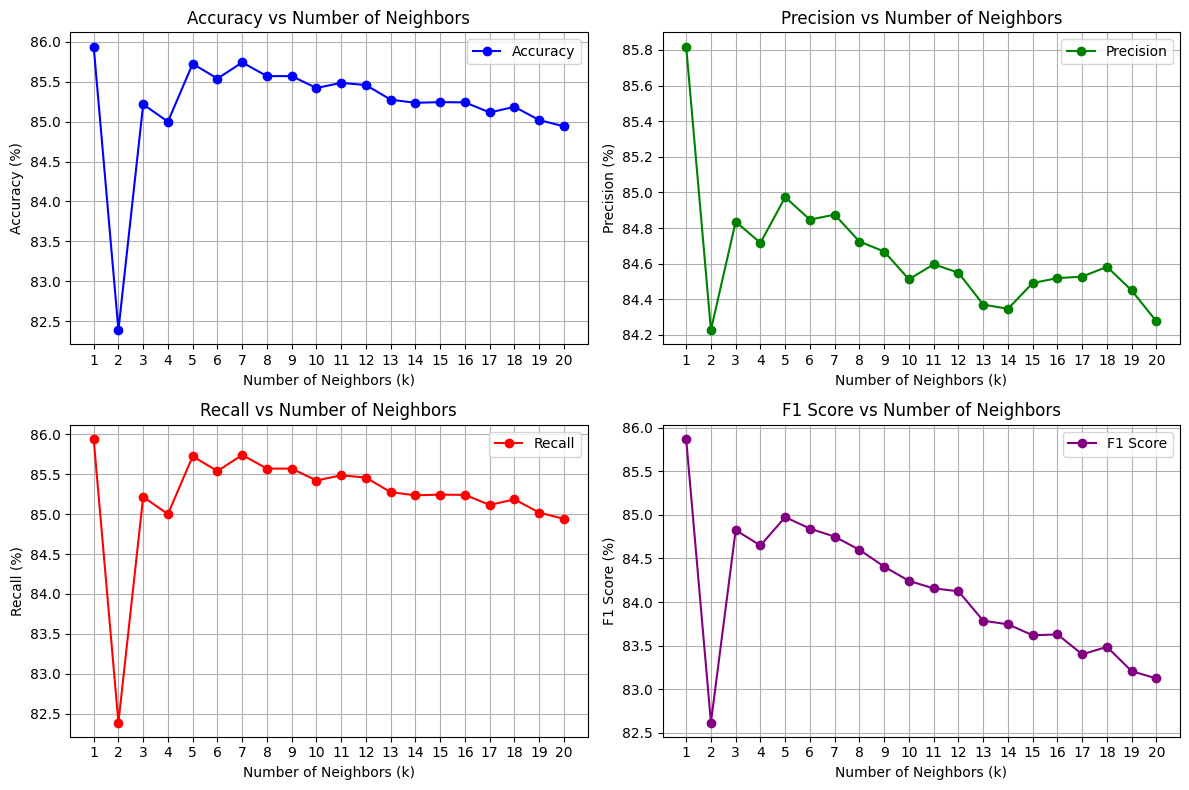

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define metrics to track
neighbors_range = range(1, 21)
accuracies, precisions, recalls, f1_scores = [], [], [], []

# Train and evaluate KNN for each value of n_neighbors
for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred) * 100)
    precisions.append(precision_score(y_test, y_pred, average='weighted') * 100)
    recalls.append(recall_score(y_test, y_pred, average='weighted') * 100)
    f1_scores.append(f1_score(y_test, y_pred, average='weighted') * 100)

# Plot metrics
plt.figure(figsize=(12, 8))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(neighbors_range, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy (%)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.legend()

# Precision Plot
plt.subplot(2, 2, 2)
plt.plot(neighbors_range, precisions, marker='o', linestyle='-', color='g', label='Precision')
plt.title('Precision vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Precision (%)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.legend()

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(neighbors_range, recalls, marker='o', linestyle='-', color='r', label='Recall')
plt.title('Recall vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Recall (%)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.legend()

# F1-Score Plot
plt.subplot(2, 2, 4)
plt.plot(neighbors_range, f1_scores, marker='o', linestyle='-', color='purple', label='F1 Score')
plt.title('F1 Score vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score (%)')
plt.xticks(neighbors_range)
plt.grid(True)
plt.legend()

# Display plots
plt.tight_layout()
plt.show()

RANDOM FOREST


In [84]:
from sklearn. ensemble import RandomForestClassifier
label_encoder = LabelEncoder()
data['VICTIM_ETHNICITY'] = label_encoder.fit_transform(data['VICTIM_ETHNICITY'].astype(str))

In [85]:
data['UCR_GROUP'] = label_encoder.fit_transform(data['UCR_GROUP'])

X = data[['UCR_GROUP']]
y = data['VICTIM_ETHNICITY']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [87]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

In [88]:
print(f"Random Forest Accuracy (using ADDRESS): {accuracy:.2f}%")
print(f"Random Forest F1-Score (using ADDRESS): {f1:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy (using ADDRESS): 93.08%
Random Forest F1-Score (using ADDRESS): 89.74%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00      1017
           3       0.00      0.00      0.00         1
           4       0.93      1.00      0.96     33135
           5       0.00      0.00      0.00      1434
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3

    accuracy                           0.93     35599
   macro avg       0.10      0.11      0.11     35599
weighted avg       0.87      0.93      0.90     35599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ONLY PCA


In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [91]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [92]:
data.fillna(data.mean(), inplace=True)

In [93]:
if 'UCR_GROUP' in data.columns:
    y = data['UCR_GROUP']
    X = data.drop(columns=['UCR_GROUP'])
else:
    X = data
    y = None

In [94]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = min(X.shape[1], 10)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [95]:
explained_variance = pca.explained_variance_ratio_ * 100

print("Explained Variance Ratios (%):")
for i, var in enumerate(explained_variance, 1):
    print(f"Principal Component {i}: {var:.2f}%")

Explained Variance Ratios (%):
Principal Component 1: 9.67%
Principal Component 2: 7.56%
Principal Component 3: 7.28%
Principal Component 4: 6.97%
Principal Component 5: 6.00%
Principal Component 6: 5.36%
Principal Component 7: 4.40%
Principal Component 8: 4.34%
Principal Component 9: 3.78%
Principal Component 10: 3.33%


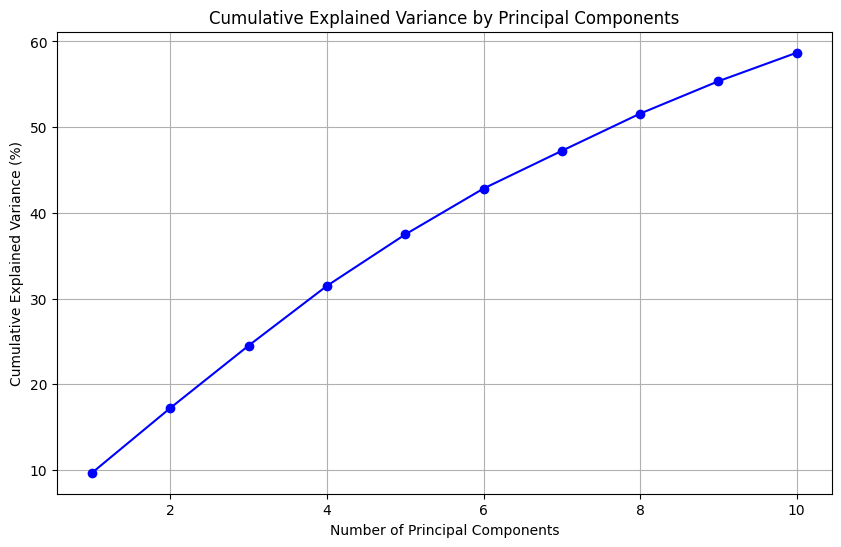

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

PCA with Random forest classifier


In [97]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [98]:
data.fillna(data.mean(), inplace=True)

In [99]:
y = data['THEFT_CODE']
X = data.drop(columns=['THEFT_CODE'])

In [100]:
X_scaled = scaler.fit_transform(X)

In [101]:
n_components = min(X.shape[1], 10)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [103]:
from sklearn. ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
y_pred = rf.predict(X_test)

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [106]:
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 89.37%
Precision: 89.57%
Recall: 89.37%
F1-Score: 88.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.08      0.14       103
           1       1.00      0.20      0.33        87
           2       0.90      0.33      0.49        27
           3       0.45      0.18      0.26      1103
           4       0.00      0.00      0.00         3
           5       0.71      0.36      0.48       902
           6       0.96      0.23      0.37        99
           7       0.48      0.73      0.58      2787
           8       1.00      0.05      0.10        76
           9       0.65      0.32      0.43      1115
          10       0.97      0.98      0.98     29297

    accuracy                           0.89     35599
   macro avg       0.73      0.32      0.38     35599
weighted avg       0.90      0.89      0.88     35599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [107]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

Text(0.5, 0, 'Metrics')

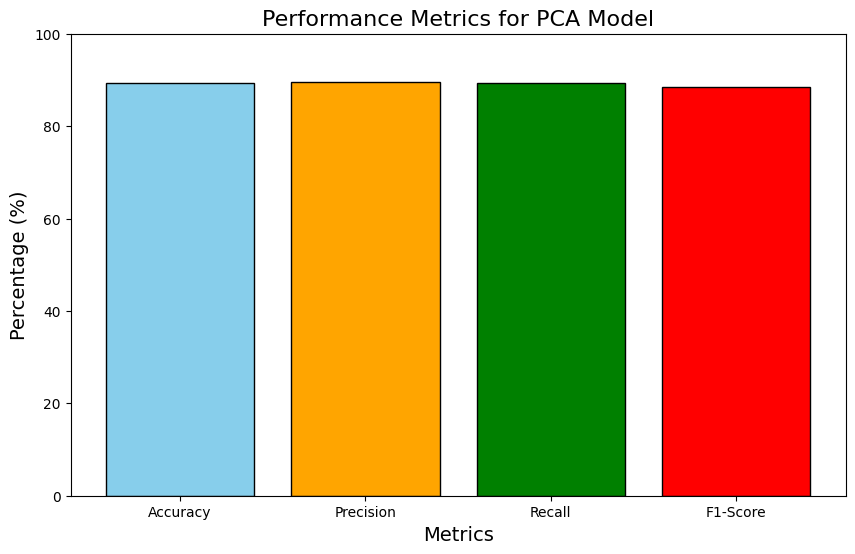

In [108]:
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'red'], edgecolor='black')
plt.ylim(0, 100)
plt.title('Performance Metrics for PCA Model', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('Metrics', fontsize=14)

SVC


In [109]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [110]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [111]:
X.fillna(X.median(), inplace=True)  # Fill numerical NaNs with median
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col].fillna("Unknown", inplace=True)

In [112]:
y = data['TOTALSUSPECTS']
X = data.drop(columns=['TOTALSUSPECTS'])

In [113]:
data.fillna(data.mean(), inplace=True)

In [114]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [115]:
sgd_svc = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [117]:
sgd_svc.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [118]:
#svm = SVC(kernel='rbf', probability=True, random_state=42)
#svm.fit(X_train, y_train)

In [119]:
#y_pred = svm.predict(X_test)

y_pred = sgd_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0) * 100

In [120]:
results = {
    "Accuracy (%)": accuracy,
    "Precision (%)": precision,
    "Recall (%)": recall,
    "F1 Score (%)": f1
}
print(results)

{'Accuracy (%)': 70.38399955054916, 'Precision (%)': 58.80704073941505, 'Recall (%)': 70.38399955054916, 'F1 Score (%)': 59.53995702118618}


In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"SVM Model Accuracy: {accuracy:.2f}%")
print(f"SVM Model Precision: {precision:.2f}%")
print(f"SVM Model Recall: {recall:.2f}%")
print(f"SVM Model F1-Score: {f1:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

SVM Model Accuracy: 70.38%
SVM Model Precision: 58.81%
SVM Model Recall: 70.38%
SVM Model F1-Score: 59.54%

Classification Report:
              precision    recall  f1-score   support

         1.0       0.71      0.99      0.83     25098
         2.0       0.35      0.02      0.04      5985
         3.0       0.19      0.03      0.04      2700
         4.0       0.33      0.00      0.01      1160
         5.0       0.00      0.00      0.00       391
         6.0       0.00      0.00      0.00       145
         7.0       0.26      0.07      0.11        74
         8.0       0.00      0.00      0.00        25
         9.0       0.00      0.00      0.00         8
        10.0       0.00      0.00      0.00        13

    accuracy                           0.70     35599
   macro avg       0.19      0.11      0.10     35599
weighted avg       0.59      0.70      0.60     35599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

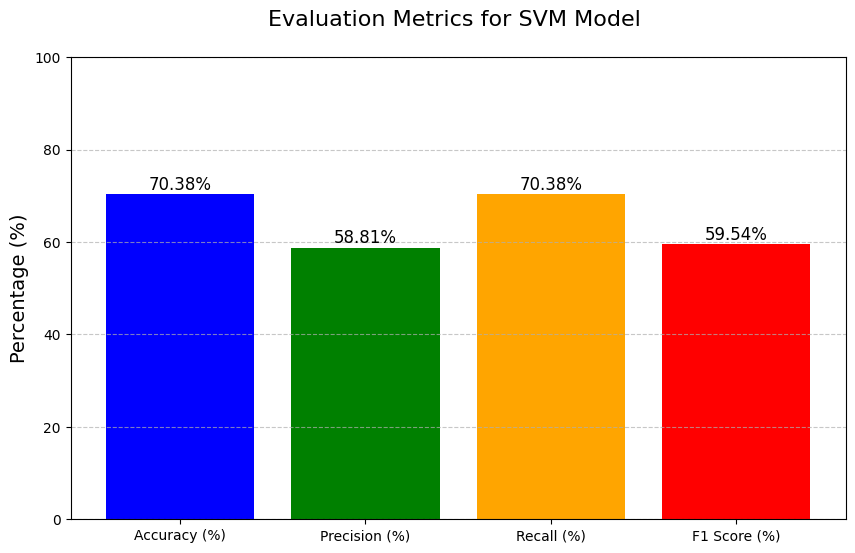

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("Evaluation Metrics for SVM Model \n", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(results.values()):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12)
plt.show()

Naive Bayes


In [123]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [124]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [125]:
data.fillna(data.mean(), inplace=True)

y = data['THEFT_CODE']
X = data.drop(columns=['THEFT_CODE'])

In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [128]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [129]:
y_pred = nb.predict(X_test)

In [130]:
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [131]:
print(f"Naive Bayes Model Accuracy: {accuracy:.2f}%")
print(f"Naive Bayes Model Precision: {precision:.2f}%")
print(f"Naive Bayes Model Recall: {recall:.2f}%")
print(f"Naive Bayes Model F1-Score: {f1:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Naive Bayes Model Accuracy: 82.91%
Naive Bayes Model Precision: 86.29%
Naive Bayes Model Recall: 82.91%
Naive Bayes Model F1-Score: 82.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.80      0.04       103
           1       0.05      0.01      0.02        87
           2       0.00      0.00      0.00        27
           3       0.20      0.01      0.02      1103
           4       0.00      0.33      0.01         3
           5       0.40      0.02      0.04       902
           6       0.03      0.64      0.07        99
           7       0.00      0.00      0.00      2787
           8       0.00      0.00      0.00        76
           9       0.75      0.04      0.08      1115
          10       1.00      1.00      1.00     29297

    accuracy                           0.83     35599
   macro avg       0.22      0.26      0.11     35599
weighted avg       0.86      0.83      0.83     35599



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [132]:
results = {
    "Accuracy (%)": accuracy,
    "Precision (%)": precision,
    "Recall (%)": recall,
    "F1 Score (%)": f1
}
print(results)

{'Accuracy (%)': 82.91244136071238, 'Precision (%)': 86.28616466864774, 'Recall (%)': 82.91244136071238, 'F1 Score (%)': 82.71245720053724}


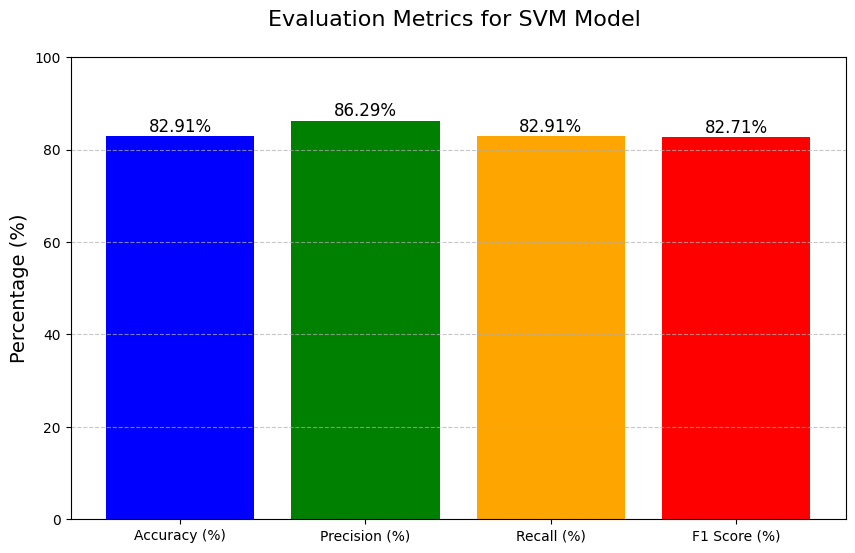

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("Evaluation Metrics for SVM Model \n", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(results.values()):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12)
plt.show()

XGBOOST

In [134]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [135]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'ZIP':  # Don't encode the target
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column].astype(str))
        label_encoders[column] = le

# Handle missing values
data.fillna(data.mean(), inplace=True)

# Step 2: Select ZIP as the target variable
y = data['SNA_NEIGHBORHOOD']  # Use the 'ZIP' column as the target
X = data.drop(columns=['SNA_NEIGHBORHOOD'])  # Drop the target column from features

# Step 3: Check if ZIP needs label encoding
if y.dtype == 'object' or isinstance(y[0], str):
    le = LabelEncoder()
    y = le.fit_transform(y)  # Encode target as numeric if necessary

# Step 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
xgb_regressor = XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = xgb_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"XGBoost Model Mean Absolute Error (MAE): {mae:.2f}")
print(f"XGBoost Model Mean Squared Error (MSE): {mse:.2f}")
print(f"XGBoost Model Root Mean Squared Error (RMSE): {rmse:.2f}")

XGBoost Model Mean Absolute Error (MAE): 0.88
XGBoost Model Mean Squared Error (MSE): 7.81
XGBoost Model Root Mean Squared Error (RMSE): 2.79


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


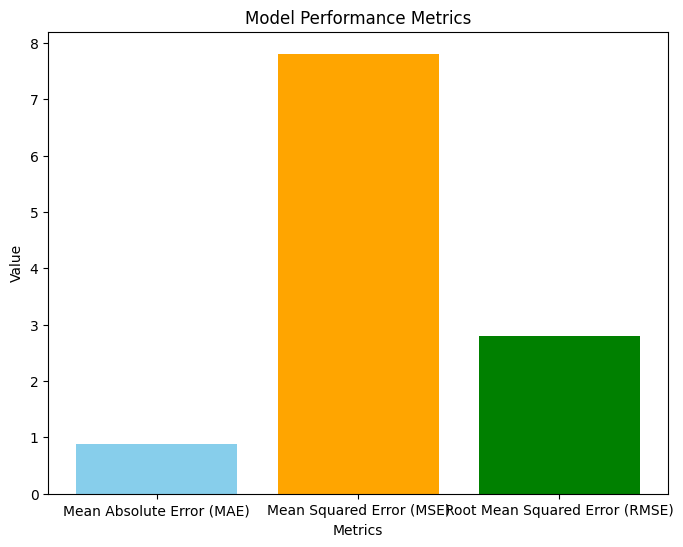

In [137]:
metrics = ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)']
values = [mae, mse, rmse]

plt.figure(figsize=(8,6))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')

# Show the plot
plt.show()

In [138]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Encode categorical columns using LabelEncoder
categorical_columns = ['LOCATION', 'SNA_NEIGHBORHOOD', 'HATE_BIAS', 'UCR_GROUP']
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data_subset[col] = label_encoders[col].fit_transform(data_subset[col])

# Scale numeric columns
scaler = MinMaxScaler()
numeric_columns = ['ZIP', 'TOTALNUMBERVICTIMS', 'TOTALSUSPECTS', 'hour_reported']
data_subset[numeric_columns] = scaler.fit_transform(data_subset[numeric_columns])

# Prepare features (X) and target (y)
X = data_subset.drop(columns=['HATE_BIAS'])
y = data_subset['HATE_BIAS']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM input: (samples, time_steps, features)
time_steps = 1  # LSTM input requires 3D data
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], time_steps, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], time_steps, X_test.shape[1]))

# Convert the target to categorical format for classification
num_classes = len(np.unique(y))  # Total number of hate bias categories
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train.shape[1]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_lstm, y_train_cat,
    epochs=10,  # Adjust the epochs as needed
    batch_size=64,
    validation_data=(X_test_lstm, y_test_cat)
)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_lstm), axis=1)
y_test_actual = np.argmax(y_test_cat, axis=1)

# Accuracy, precision, recall, and F1-score
accuracy = (y_pred == y_test_actual).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1481/1481 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8480 - loss: 0.5775 - val_accuracy: 0.9359 - val_loss: 0.2052
Epoch 2/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9363 - loss: 0.2338 - val_accuracy: 0.9581 - val_loss: 0.1736
Epoch 3/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9513 - loss: 0.2022 - val_accuracy: 0.9643 - val_loss: 0.1611
Epoch 4/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9550 - loss: 0.1915 - val_accuracy: 0.9647 - val_loss: 0.1556
Epoch 5/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9584 - loss: 0.1852 - val_accuracy: 0.9647 - val_loss: 0.1595
Epoch 6/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9584 - loss: 0.1821 - val_accuracy: 0.9647 - val_loss: 0.1559
Epoch 7/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9578 - loss: 0.1844 - val_accuracy: 0.9651 - val_loss: 0.1545
Epoch 8/10
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9604 - loss: 0.1742 - val_accura

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test_actual, y_pred) * 100
precision = precision_score(y_test_actual, y_pred, average='weighted') * 100
recall = recall_score(y_test_actual, y_pred, average='weighted') * 100
f1 = f1_score(y_test_actual, y_pred, average='weighted') * 100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
results = {
    "Accuracy (%)": accuracy,
    "Precision (%)": precision,
    "Recall (%)": recall,
    "F1 Score (%)": f1
}
print(results)

{'Accuracy (%)': 96.52464000675647, 'Precision (%)': 96.2122872795725, 'Recall (%)': 96.52464000675647, 'F1 Score (%)': 96.22560911275632}


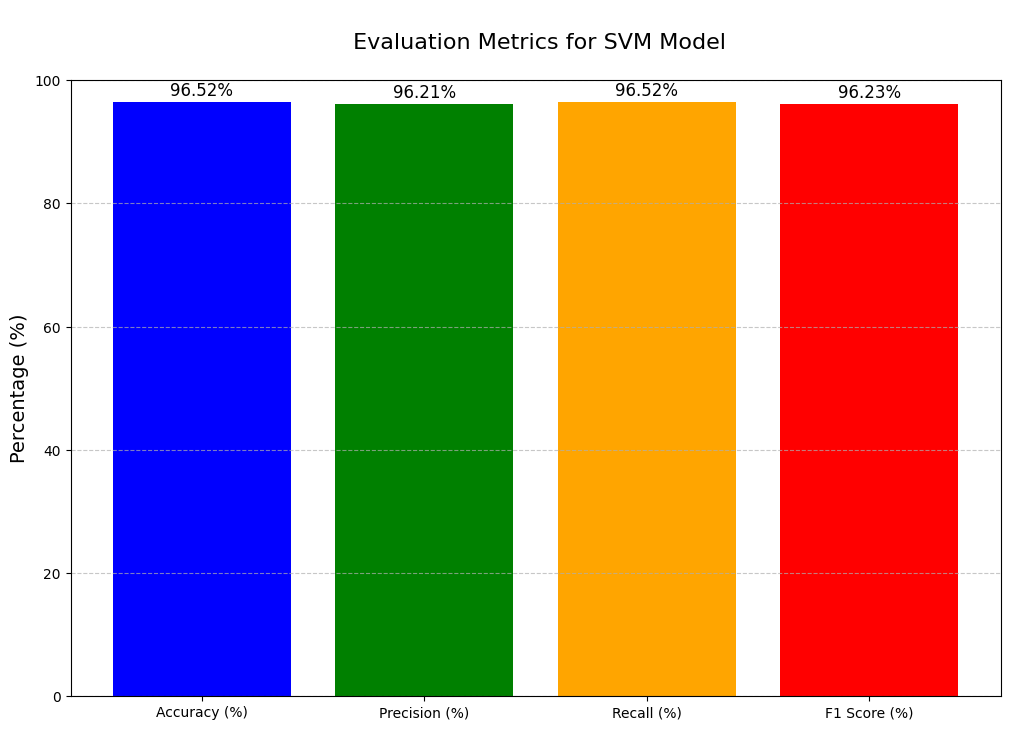

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("\n Evaluation Metrics for SVM Model\n", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, value in enumerate(results.values()):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12)
plt.show()

In [142]:


# file_path = '/content/drive/MyDrive/Datasets/cleaned_cincinati_data.csv'
# data = pd.read_csv(file_path, low_memory=False)

def remove_value_from_column(data, column_name, value_to_remove):
    filtered_data = data[data[column_name] != value_to_remove]
    return filtered_data

from sklearn.preprocessing import LabelEncoder

def preprocess_data(data, target_column):
    columns_to_drop = ['VICTIM_RACE', 'SUSPECT_RACE', 'LONGITUDE', 'LATITUDE']
    columns_to_drop = list(set(columns_to_drop).intersection(data.columns))
    data = data.drop(columns=columns_to_drop)

    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].fillna('Unknown')

    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col] = data[col].fillna(data[col].mean())

    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].astype(str)

    label_encoders = {}
    for col in data.select_dtypes(include='object').columns:
        if col != target_column:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le

    data = data.dropna(subset=[target_column])

    target_encoder = LabelEncoder()
    data[target_column] = target_encoder.fit_transform(data[target_column])

    return data, target_encoder




def build_and_train_model_with_metrics(data, target_column):
    data, target_encoder = preprocess_data(data, target_column)

    X = data.drop(columns=[target_column])
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = GradientBoostingClassifier(random_state=42, n_estimators=50)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Performance on {target_column}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy}")

    plt.figure(figsize=(25, 17))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
    plt.title(f"Confusion Matrix for {target_column}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, target_encoder


In [143]:
column_to_filter = 'UCR_GROUP'
value_to_remove = 'Unknown'
filtered_data = remove_value_from_column(data_subset, column_to_filter, value_to_remove)
data.head()


,INCIDENT_NO,DATE_REPORTED,DATE_FROM,DATE_TO,CLSD,UCR,DST,BEAT,OFFENSE,LOCATION,...,SUSPECT_RACE,SUSPECT_ETHNICITY,SUSPECT_GENDER,TOTALNUMBERVICTIMS,TOTALSUSPECTS,UCR_GROUP,ZIP,SNA_NEIGHBORHOOD,date_reported,time_reported
0,80763,76293,69263,73415,5,1493.0,2,4,15,8,...,3,3,1,1.0,1.0,3,45211.0,48,2903,13513
1,80760,76289,69250,73403,12,810.0,3,4,10,6,...,3,3,1,1.0,1.0,3,45229.0,0,2903,10135
2,80761,76287,69260,73412,3,303.0,3,10,6,54,...,3,3,1,1.0,2.0,5,45216.0,4,2903,8400
3,80761,76287,69260,73412,3,303.0,3,10,6,54,...,3,3,1,1.0,2.0,5,45216.0,4,2903,8400
4,80759,76284,69258,73410,7,802.0,2,2,4,8,...,3,3,1,1.0,1.0,3,45205.0,12,2903,7686


In [144]:
filtered_data.head()

,LOCATION,SNA_NEIGHBORHOOD,ZIP,HATE_BIAS,TOTALNUMBERVICTIMS,TOTALSUSPECTS,UCR_GROUP,OFFENSE,hour_reported
0,8,49,0.169811,16,0.0,0.0000,3,15,1.000000
1,6,0,0.509434,16,0.0,0.0000,3,10,0.869565
2,54,4,0.264151,16,0.0,0.0625,5,6,0.826087
3,54,4,0.264151,16,0.0,0.0625,5,6,0.826087
4,8,12,0.056604,16,0.0,0.0000,3,4,0.782609


Predicting UCR_GROUP...
Performance on UCR_GROUP:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1721
           1       1.00      1.00      1.00      1551
           2       0.99      1.00      1.00       113
           3       1.00      1.00      1.00     12994
           4       1.00      1.00      1.00       386
           5       1.00      1.00      1.00      2503
           6       1.00      1.00      1.00      4094
           7       1.00      1.00      1.00       317
           8       1.00      1.00      1.00         2

    accuracy                           1.00     23681
   macro avg       1.00      1.00      1.00     23681
weighted avg       1.00      1.00      1.00     23681

Accuracy: 0.9998733161606351


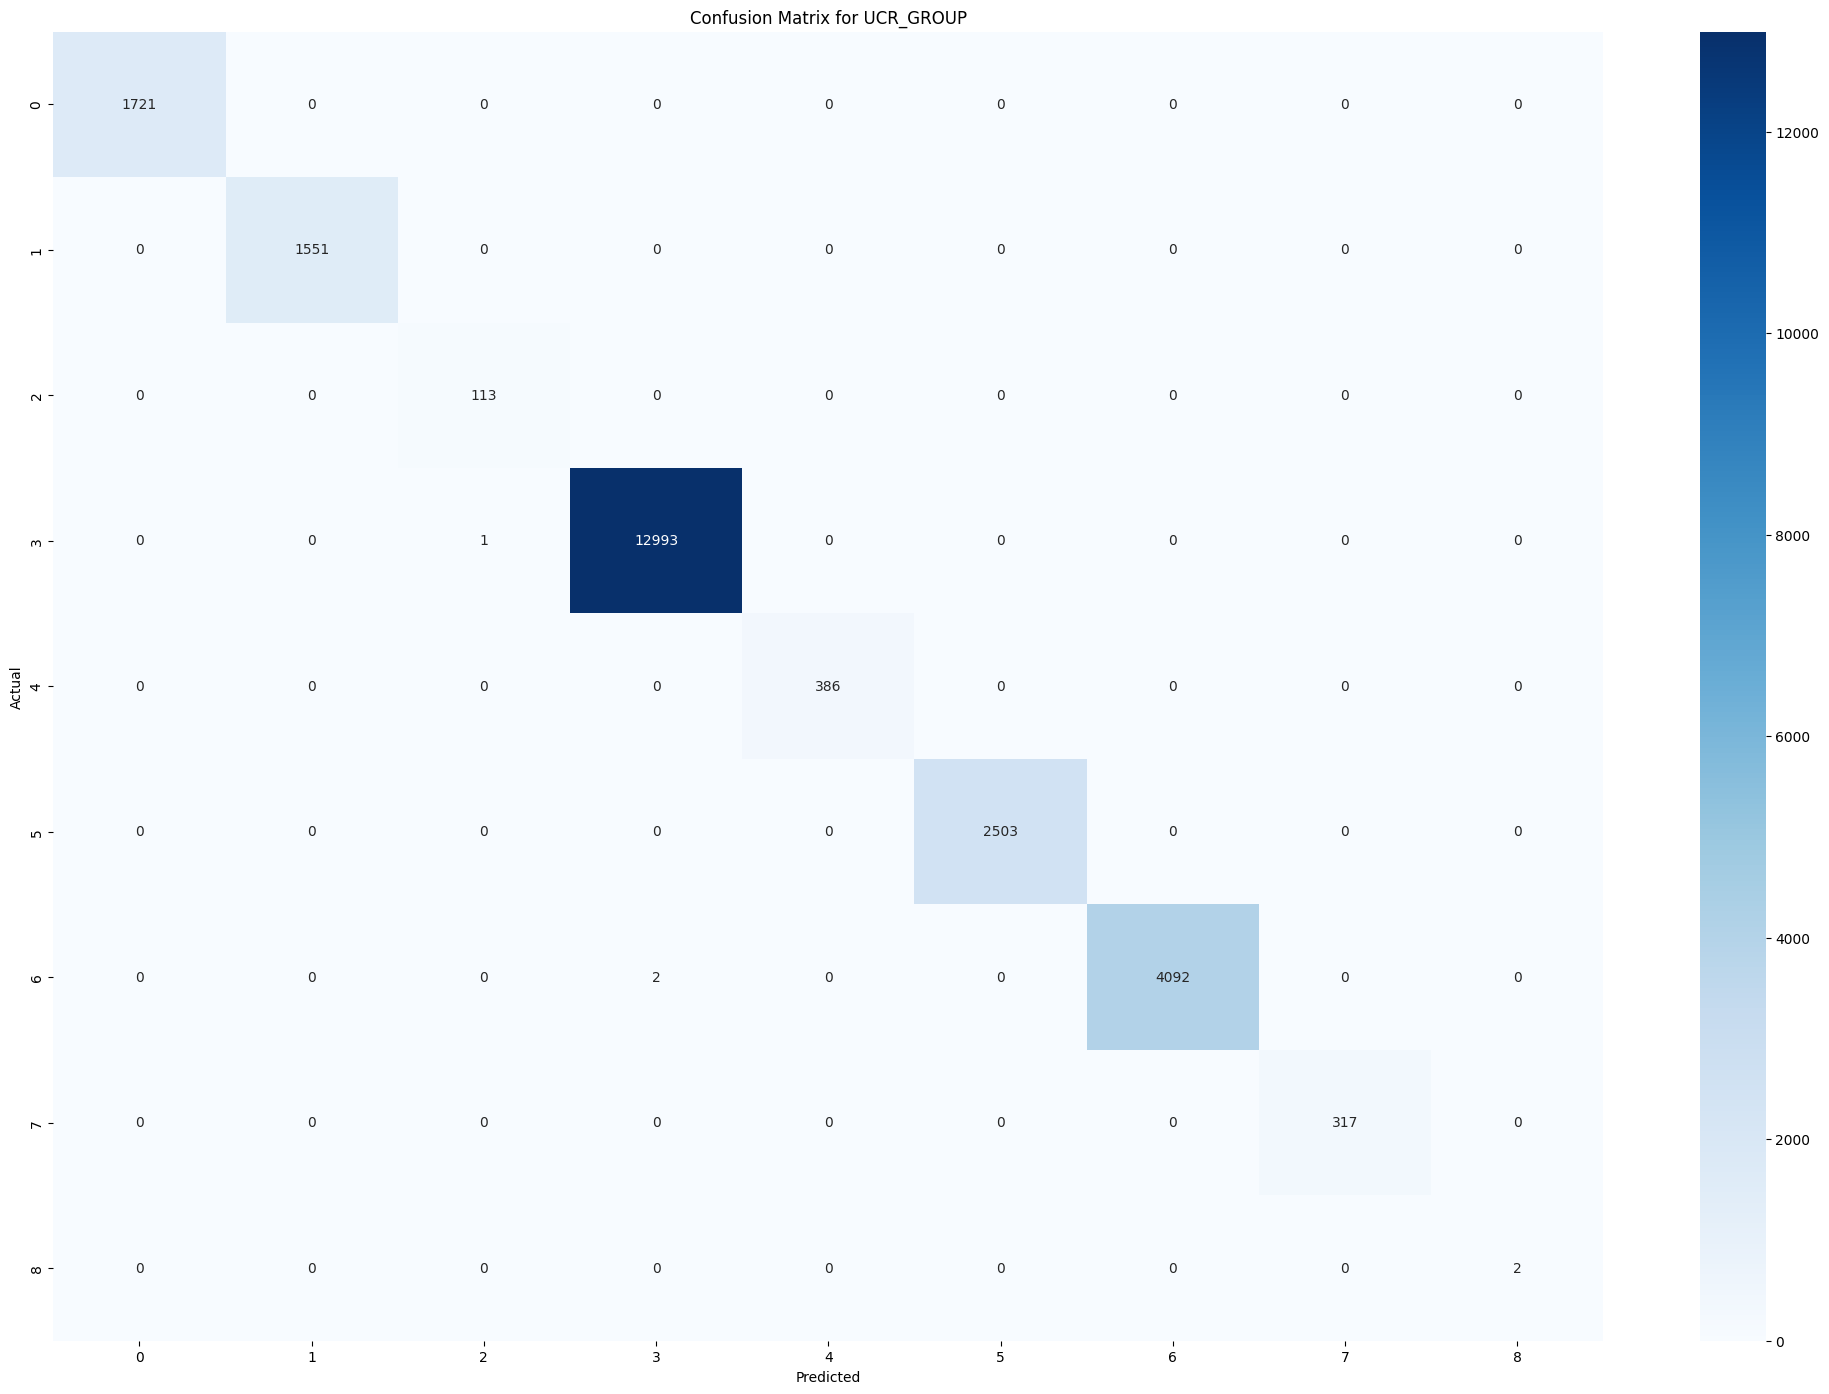

In [145]:
print("Predicting UCR_GROUP...")
ucr_model, ucr_encoder = build_and_train_model_with_metrics(filtered_data, 'UCR_GROUP')